In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from constant import AFFECTNETPATH

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file,base_path,transform=None):
        self.fields = ['subDirectory_filePath', 'expression','valence','arousal']
        self._table = pd.read_csv(csv_file,usecols=self.fields)
        
        self._table=self._table[self._table['expression'] <8]

        self._table=self._table.reset_index(drop=True)

        self._base_path=base_path
   



        self.transform=transforms.Compose([
                     transforms.Resize((32,32)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])

    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path,self._table.subDirectory_filePath[idx])
        img=Image.open(folder_name)
        img=self.transform(img)
        valence = torch.from_numpy(np.array(self._table.valence[idx]))
        return (img,valence.float())
            
        

In [3]:
Affect_Train=ImageDataset('training.csv',AFFECTNETPATH)
Affect_Valid=ImageDataset('validation.csv',AFFECTNETPATH)

In [4]:
import csv
def import_data(filename):
    """Import data in the second column of the supplied filename as floats."""
    with open(filename, 'r') as inf:
        inf.readline()
        return [float(row[2]) for row in csv.reader(inf)]

In [5]:
len(Affect_Train)

287652

In [6]:
train_dataloader = DataLoader(Affect_Train, batch_size=64
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(Affect_Valid, batch_size=64
                       , num_workers=0)    

In [7]:
len(train_dataloader)

4495

In [8]:
Affect_Train[26][0].shape



torch.Size([3, 32, 32])

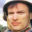

In [9]:
img=transforms.ToPILImage()(Affect_Train[26][0]*0.5+0.5)
img


In [10]:
from module import face_feature

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

model=face_feature.Face_Feature()
model=model.to(device)

In [12]:
device

device(type='cuda', index=0)

In [13]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [14]:
model(Affect_Train[0][0].unsqueeze(0).to(device))

tensor([[0.3613]], grad_fn=<TanhBackward>)

In [15]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, betas=(0.5, 0.999))

In [16]:
from tqdm.notebook import tqdm

In [17]:
train_loss=[]
val_loss=[]
num_epochs=50

for epochs in (range(0,num_epochs)):
    model.train()
    print("Training Epoch: ", epochs+1,"\n")
   
    for i_batch, (img,valence) in tqdm(enumerate(train_dataloader)):
        batch_size=img.size(0)
        optimizer.zero_grad()
        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        loss=loss1
        loss.backward()
        optimizer.step()
        if i_batch%250==0:
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("MSE loss: ", loss.item())
            train_loss.append(loss.item())
    model.eval()
    avg_loss=1e-6
    temp_loss=0
    for i_batch, (img,valence) in enumerate(valid_dataloader):
        
        batch_size=img.size(0)

        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        #loss2=loss_func(arou_output,valence.to(device))
        loss=loss1
        temp_loss+=loss.item()
    print("ValidationLoss: ",temp_loss/len(valid_dataloader))
    val_loss.append(temp_loss/len(valid_dataloader))
    if temp_loss<avg_loss:
        avg_loss=temp_loss
        torch.save(model,"face_feature.h")
    

    

    
        

Training Epoch:  1 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 4495
MSE loss:  0.2616032361984253
Batch:  251 / 4495
MSE loss:  0.2894498407840729
Batch:  501 / 4495
MSE loss:  0.29474470019340515
Batch:  751 / 4495
MSE loss:  0.2834385633468628
Batch:  1001 / 4495
MSE loss:  0.24670641124248505
Batch:  1251 / 4495
MSE loss:  0.3150092661380768
Batch:  1501 / 4495
MSE loss:  0.29874780774116516
Batch:  1751 / 4495
MSE loss:  0.23826083540916443
Batch:  2001 / 4495
MSE loss:  0.33283182978630066
Batch:  2251 / 4495
MSE loss:  0.2320093959569931
Batch:  2501 / 4495
MSE loss:  0.2953333556652069
Batch:  2751 / 4495
MSE loss:  0.27640900015830994
Batch:  3001 / 4495
MSE loss:  0.29040369391441345
Batch:  3251 / 4495
MSE loss:  0.2682853937149048
Batch:  3501 / 4495
MSE loss:  0.23518404364585876
Batch:  3751 / 4495
MSE loss:  0.2803976833820343
Batch:  4001 / 4495
MSE loss:  0.279130756855011
Batch:  4251 / 4495
MSE loss:  0.2473221719264984


/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



ValidationLoss:  0.3586247061926221
Training Epoch:  2 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 4495
MSE loss:  0.2544076442718506
Batch:  251 / 4495
MSE loss:  0.3091084957122803
Batch:  501 / 4495
MSE loss:  0.2346215844154358
Batch:  751 / 4495
MSE loss:  0.29820215702056885
Batch:  1001 / 4495
MSE loss:  0.2542441487312317
Batch:  1251 / 4495
MSE loss:  0.24393805861473083
Batch:  1501 / 4495
MSE loss:  0.258212685585022
Batch:  1751 / 4495
MSE loss:  0.2889578938484192
Batch:  2001 / 4495
MSE loss:  0.26300787925720215
Batch:  2251 / 4495
MSE loss:  0.2597668766975403
Batch:  2501 / 4495
MSE loss:  0.26610711216926575
Batch:  2751 / 4495
MSE loss:  0.2652439475059509
Batch:  3001 / 4495
MSE loss:  0.22981859743595123
Batch:  3251 / 4495
MSE loss:  0.27491411566734314
Batch:  3501 / 4495
MSE loss:  0.3416329026222229
Batch:  3751 / 4495
MSE loss:  0.3093251883983612
Batch:  4001 / 4495
MSE loss:  0.29336774349212646
Batch:  4251 / 4495
MSE loss:  0.24237269163131714

ValidationLoss:  0.3608336302023085
Training Epoch:  3 



Batch:  1 / 4495
MSE loss:  0.21995413303375244
Batch:  251 / 4495
MSE loss:  0.2805308401584625
Batch:  501 / 4495
MSE loss:  0.24412541091442108
Batch:  751 / 4495
MSE loss:  0.30088257789611816
Batch:  1001 / 4495
MSE loss:  0.274685800075531
Batch:  1251 / 4495
MSE loss:  0.2532743215560913
Batch:  1501 / 4495
MSE loss:  0.2910417914390564
Batch:  1751 / 4495
MSE loss:  0.2350074201822281
Batch:  2001 / 4495
MSE loss:  0.23949529230594635
Batch:  2251 / 4495
MSE loss:  0.2416316717863083
Batch:  2501 / 4495
MSE loss:  0.2821786403656006
Batch:  2751 / 4495
MSE loss:  0.2382018268108368
Batch:  3001 / 4495
MSE loss:  0.32062387466430664
Batch:  3251 / 4495
MSE loss:  0.21797537803649902
Batch:  3501 / 4495
MSE loss:  0.22326627373695374
Batch:  3751 / 4495
MSE loss:  0.24357451498508453
Batch:  4001 / 4495
MSE loss:  0.23959022760391235
Batch:  4251 / 4495
MSE loss:  0.2915809154510498

ValidationLoss:  0.36655757824579877
Training Epoch:  4 



Batch:  1 / 4495
MSE loss:  0.2856583595275879
Batch:  251 / 4495
MSE loss:  0.28489604592323303
Batch:  501 / 4495
MSE loss:  0.22230035066604614
Batch:  751 / 4495
MSE loss:  0.28413140773773193
Batch:  1001 / 4495
MSE loss:  0.28254279494285583
Batch:  1251 / 4495
MSE loss:  0.28924256563186646
Batch:  1501 / 4495
MSE loss:  0.2563042640686035
Batch:  1751 / 4495
MSE loss:  0.21894042193889618
Batch:  2001 / 4495
MSE loss:  0.25870662927627563
Batch:  2251 / 4495
MSE loss:  0.2488671839237213
Batch:  2501 / 4495
MSE loss:  0.30272579193115234
Batch:  2751 / 4495
MSE loss:  0.23705367743968964
Batch:  3001 / 4495
MSE loss:  0.224333256483078
Batch:  3251 / 4495
MSE loss:  0.2950679659843445
Batch:  3501 / 4495
MSE loss:  0.2775559425354004
Batch:  3751 / 4495
MSE loss:  0.36434614658355713
Batch:  4001 / 4495
MSE loss:  0.21654391288757324
Batch:  4251 / 4495
MSE loss:  0.20772352814674377

ValidationLoss:  0.37002621094385785
Training Epoch:  5 



Batch:  1 / 4495
MSE loss:  0.309796005487442
Batch:  251 / 4495
MSE loss:  0.24300655722618103
Batch:  501 / 4495
MSE loss:  0.21483848989009857
Batch:  751 / 4495
MSE loss:  0.2785455286502838
Batch:  1001 / 4495
MSE loss:  0.21939687430858612
Batch:  1251 / 4495
MSE loss:  0.26988548040390015
Batch:  1501 / 4495
MSE loss:  0.27663809061050415
Batch:  1751 / 4495
MSE loss:  0.2467995434999466
Batch:  2001 / 4495
MSE loss:  0.29350724816322327
Batch:  2251 / 4495
MSE loss:  0.22819727659225464
Batch:  2501 / 4495
MSE loss:  0.23908989131450653
Batch:  2751 / 4495
MSE loss:  0.2982200086116791
Batch:  3001 / 4495
MSE loss:  0.2905721664428711
Batch:  3251 / 4495
MSE loss:  0.22590923309326172
Batch:  3501 / 4495
MSE loss:  0.2538495361804962
Batch:  3751 / 4495
MSE loss:  0.2577786147594452
Batch:  4001 / 4495
MSE loss:  0.34533125162124634
Batch:  4251 / 4495
MSE loss:  0.21729756891727448

ValidationLoss:  0.35671529741514296
Training Epoch:  6 



Batch:  1 / 4495
MSE loss:  0.2628100514411926
Batch:  251 / 4495
MSE loss:  0.21488633751869202
Batch:  501 / 4495
MSE loss:  0.22854852676391602
Batch:  751 / 4495
MSE loss:  0.2634750306606293
Batch:  1001 / 4495
MSE loss:  0.2710864245891571
Batch:  1251 / 4495
MSE loss:  0.3060791492462158
Batch:  1501 / 4495
MSE loss:  0.281310111284256
Batch:  1751 / 4495
MSE loss:  0.29024580121040344
Batch:  2001 / 4495
MSE loss:  0.2875324487686157
Batch:  2251 / 4495
MSE loss:  0.2469840943813324
Batch:  2501 / 4495
MSE loss:  0.2834532856941223
Batch:  2751 / 4495
MSE loss:  0.23345708847045898
Batch:  3001 / 4495
MSE loss:  0.24086375534534454
Batch:  3251 / 4495
MSE loss:  0.25908368825912476
Batch:  3501 / 4495
MSE loss:  0.24264998733997345
Batch:  3751 / 4495
MSE loss:  0.2701762616634369
Batch:  4001 / 4495
MSE loss:  0.2622821629047394
Batch:  4251 / 4495
MSE loss:  0.26278796792030334

ValidationLoss:  0.3638691433838436
Training Epoch:  7 



Batch:  1 / 4495
MSE loss:  0.25175613164901733
Batch:  251 / 4495
MSE loss:  0.22717517614364624
Batch:  501 / 4495
MSE loss:  0.29078367352485657
Batch:  751 / 4495
MSE loss:  0.2980148494243622
Batch:  1001 / 4495
MSE loss:  0.25383633375167847
Batch:  1251 / 4495
MSE loss:  0.28812143206596375
Batch:  1501 / 4495
MSE loss:  0.28753331303596497
Batch:  1751 / 4495
MSE loss:  0.273676335811615
Batch:  2001 / 4495
MSE loss:  0.21975301206111908
Batch:  2251 / 4495
MSE loss:  0.30539581179618835
Batch:  2501 / 4495
MSE loss:  0.302015095949173
Batch:  2751 / 4495
MSE loss:  0.23888736963272095
Batch:  3001 / 4495
MSE loss:  0.21443703770637512
Batch:  3251 / 4495
MSE loss:  0.23537509143352509
Batch:  3501 / 4495
MSE loss:  0.2700815796852112
Batch:  3751 / 4495
MSE loss:  0.2629227638244629
Batch:  4001 / 4495
MSE loss:  0.3019091486930847
Batch:  4251 / 4495
MSE loss:  0.2508099377155304

ValidationLoss:  0.363874363047736
Training Epoch:  8 



Batch:  1 / 4495
MSE loss:  0.28992581367492676
Batch:  251 / 4495
MSE loss:  0.30760836601257324
Batch:  501 / 4495
MSE loss:  0.2462511658668518
Batch:  751 / 4495
MSE loss:  0.35622310638427734
Batch:  1001 / 4495
MSE loss:  0.3019132614135742
Batch:  1251 / 4495
MSE loss:  0.26492637395858765
Batch:  1501 / 4495
MSE loss:  0.2539123594760895
Batch:  1751 / 4495
MSE loss:  0.21688009798526764
Batch:  2001 / 4495
MSE loss:  0.2775091528892517
Batch:  2251 / 4495
MSE loss:  0.2998894453048706
Batch:  2501 / 4495
MSE loss:  0.31058162450790405
Batch:  2751 / 4495
MSE loss:  0.301958829164505
Batch:  3001 / 4495
MSE loss:  0.289069265127182
Batch:  3251 / 4495
MSE loss:  0.24923372268676758
Batch:  3501 / 4495
MSE loss:  0.24804750084877014
Batch:  3751 / 4495
MSE loss:  0.29286015033721924
Batch:  4001 / 4495
MSE loss:  0.2623721659183502
Batch:  4251 / 4495
MSE loss:  0.2965948283672333

ValidationLoss:  0.3584743198894319
Training Epoch:  9 



Batch:  1 / 4495
MSE loss:  0.23599642515182495
Batch:  251 / 4495
MSE loss:  0.22131964564323425
Batch:  501 / 4495
MSE loss:  0.3107152283191681
Batch:  751 / 4495
MSE loss:  0.28403669595718384
Batch:  1001 / 4495
MSE loss:  0.2424640953540802
Batch:  1251 / 4495
MSE loss:  0.22711247205734253
Batch:  1501 / 4495
MSE loss:  0.2859644591808319
Batch:  1751 / 4495
MSE loss:  0.3018537163734436
Batch:  2001 / 4495
MSE loss:  0.31711113452911377
Batch:  2251 / 4495
MSE loss:  0.26733240485191345
Batch:  2501 / 4495
MSE loss:  0.262451708316803
Batch:  2751 / 4495
MSE loss:  0.264941930770874
Batch:  3001 / 4495
MSE loss:  0.29487019777297974
Batch:  3251 / 4495
MSE loss:  0.2771269977092743
Batch:  3501 / 4495
MSE loss:  0.2738010883331299
Batch:  3751 / 4495
MSE loss:  0.2253684103488922
Batch:  4001 / 4495
MSE loss:  0.2596566081047058
Batch:  4251 / 4495
MSE loss:  0.25543922185897827

ValidationLoss:  0.36400678517326474
Training Epoch:  10 



Batch:  1 / 4495
MSE loss:  0.22890877723693848
Batch:  251 / 4495
MSE loss:  0.24043215811252594
Batch:  501 / 4495
MSE loss:  0.27552545070648193
Batch:  751 / 4495
MSE loss:  0.26519134640693665
Batch:  1001 / 4495
MSE loss:  0.26032429933547974
Batch:  1251 / 4495
MSE loss:  0.2324829399585724
Batch:  1501 / 4495
MSE loss:  0.2701457440853119
Batch:  1751 / 4495
MSE loss:  0.232914999127388
Batch:  2001 / 4495
MSE loss:  0.2661180794239044
Batch:  2251 / 4495
MSE loss:  0.2266695648431778
Batch:  2501 / 4495
MSE loss:  0.304159939289093
Batch:  2751 / 4495
MSE loss:  0.2856813371181488
Batch:  3001 / 4495
MSE loss:  0.2604008615016937
Batch:  3251 / 4495
MSE loss:  0.2432796061038971
Batch:  3501 / 4495
MSE loss:  0.291564017534256
Batch:  3751 / 4495
MSE loss:  0.29550135135650635
Batch:  4001 / 4495
MSE loss:  0.21055328845977783
Batch:  4251 / 4495
MSE loss:  0.3054041564464569

ValidationLoss:  0.3679795265197754
Training Epoch:  11 



Batch:  1 / 4495
MSE loss:  0.2435947209596634
Batch:  251 / 4495
MSE loss:  0.2781248688697815
Batch:  501 / 4495
MSE loss:  0.28281185030937195
Batch:  751 / 4495
MSE loss:  0.23605625331401825
Batch:  1001 / 4495
MSE loss:  0.2571215331554413
Batch:  1251 / 4495
MSE loss:  0.2681638300418854
Batch:  1501 / 4495
MSE loss:  0.2952759563922882
Batch:  1751 / 4495
MSE loss:  0.2521822452545166
Batch:  2001 / 4495
MSE loss:  0.24227264523506165
Batch:  2251 / 4495
MSE loss:  0.31659621000289917
Batch:  2501 / 4495
MSE loss:  0.24381625652313232
Batch:  2751 / 4495
MSE loss:  0.25050079822540283
Batch:  3001 / 4495
MSE loss:  0.2810208201408386
Batch:  3251 / 4495
MSE loss:  0.21359682083129883
Batch:  3501 / 4495
MSE loss:  0.2674649655818939
Batch:  3751 / 4495
MSE loss:  0.23591318726539612
Batch:  4001 / 4495
MSE loss:  0.25173768401145935
Batch:  4251 / 4495
MSE loss:  0.2579847276210785

ValidationLoss:  0.36476912526857286
Training Epoch:  12 



Batch:  1 / 4495
MSE loss:  0.2271188199520111
Batch:  251 / 4495
MSE loss:  0.3002868890762329
Batch:  501 / 4495
MSE loss:  0.27250221371650696
Batch:  751 / 4495
MSE loss:  0.3066633939743042
Batch:  1001 / 4495
MSE loss:  0.26680663228034973
Batch:  1251 / 4495
MSE loss:  0.33015161752700806
Batch:  1501 / 4495
MSE loss:  0.2606930732727051
Batch:  1751 / 4495
MSE loss:  0.36241763830184937
Batch:  2001 / 4495
MSE loss:  0.24852360785007477
Batch:  2251 / 4495
MSE loss:  0.23056428134441376
Batch:  2501 / 4495
MSE loss:  0.20750795304775238
Batch:  2751 / 4495
MSE loss:  0.2924427390098572
Batch:  3001 / 4495
MSE loss:  0.23541410267353058
Batch:  3251 / 4495
MSE loss:  0.22066447138786316
Batch:  3501 / 4495
MSE loss:  0.2583231031894684
Batch:  3751 / 4495
MSE loss:  0.29221227765083313
Batch:  4001 / 4495
MSE loss:  0.2492993175983429
Batch:  4251 / 4495
MSE loss:  0.2732778489589691

ValidationLoss:  0.36603513076191857
Training Epoch:  13 



Batch:  1 / 4495
MSE loss:  0.301667183637619
Batch:  251 / 4495
MSE loss:  0.27182161808013916
Batch:  501 / 4495
MSE loss:  0.24813717603683472
Batch:  751 / 4495
MSE loss:  0.26439717411994934
Batch:  1001 / 4495
MSE loss:  0.2710326910018921
Batch:  1251 / 4495
MSE loss:  0.278982013463974
Batch:  1501 / 4495
MSE loss:  0.2562887668609619
Batch:  1751 / 4495
MSE loss:  0.25635823607444763
Batch:  2001 / 4495
MSE loss:  0.22309096157550812
Batch:  2251 / 4495
MSE loss:  0.25668543577194214
Batch:  2501 / 4495
MSE loss:  0.2752002775669098
Batch:  2751 / 4495
MSE loss:  0.23043178021907806
Batch:  3001 / 4495
MSE loss:  0.26162639260292053
Batch:  3251 / 4495
MSE loss:  0.22808344662189484
Batch:  3501 / 4495
MSE loss:  0.2560046911239624
Batch:  3751 / 4495
MSE loss:  0.357707679271698
Batch:  4001 / 4495
MSE loss:  0.26000139117240906
Batch:  4251 / 4495
MSE loss:  0.28678011894226074

ValidationLoss:  0.36912151981913854
Training Epoch:  14 



Batch:  1 / 4495
MSE loss:  0.33719268441200256
Batch:  251 / 4495
MSE loss:  0.311206191778183
Batch:  501 / 4495
MSE loss:  0.287871390581131
Batch:  751 / 4495
MSE loss:  0.325888991355896
Batch:  1001 / 4495
MSE loss:  0.30498045682907104
Batch:  1251 / 4495
MSE loss:  0.24063292145729065
Batch:  1501 / 4495
MSE loss:  0.2685384154319763
Batch:  1751 / 4495
MSE loss:  0.275663822889328
Batch:  2001 / 4495
MSE loss:  0.29823392629623413
Batch:  2251 / 4495
MSE loss:  0.3162981867790222
Batch:  2501 / 4495
MSE loss:  0.29733896255493164
Batch:  2751 / 4495
MSE loss:  0.23724591732025146
Batch:  3001 / 4495
MSE loss:  0.2966912090778351
Batch:  3251 / 4495
MSE loss:  0.3193581700325012
Batch:  3501 / 4495
MSE loss:  0.2191992849111557
Batch:  3751 / 4495
MSE loss:  0.23256053030490875
Batch:  4001 / 4495
MSE loss:  0.26471370458602905
Batch:  4251 / 4495
MSE loss:  0.3603721857070923

ValidationLoss:  0.36252986675217036
Training Epoch:  15 



Batch:  1 / 4495
MSE loss:  0.2653856575489044
Batch:  251 / 4495
MSE loss:  0.2509768605232239
Batch:  501 / 4495
MSE loss:  0.2744523584842682
Batch:  751 / 4495
MSE loss:  0.2475866824388504
Batch:  1001 / 4495
MSE loss:  0.20784330368041992
Batch:  1251 / 4495
MSE loss:  0.26657435297966003
Batch:  1501 / 4495
MSE loss:  0.30896076560020447
Batch:  1751 / 4495
MSE loss:  0.25710028409957886
Batch:  2001 / 4495
MSE loss:  0.2894873023033142
Batch:  2251 / 4495
MSE loss:  0.2591668367385864
Batch:  2501 / 4495
MSE loss:  0.28452426195144653
Batch:  2751 / 4495
MSE loss:  0.23437324166297913
Batch:  3001 / 4495
MSE loss:  0.254718542098999
Batch:  3251 / 4495
MSE loss:  0.19658944010734558
Batch:  3501 / 4495
MSE loss:  0.2141839861869812
Batch:  3751 / 4495
MSE loss:  0.2911771833896637
Batch:  4001 / 4495
MSE loss:  0.31654632091522217
Batch:  4251 / 4495
MSE loss:  0.25937771797180176

ValidationLoss:  0.36039879445045714
Training Epoch:  16 



Batch:  1 / 4495
MSE loss:  0.28278982639312744
Batch:  251 / 4495
MSE loss:  0.29914402961730957
Batch:  501 / 4495
MSE loss:  0.3130379021167755
Batch:  751 / 4495
MSE loss:  0.31589657068252563
Batch:  1001 / 4495
MSE loss:  0.24478401243686676
Batch:  1251 / 4495
MSE loss:  0.2939109802246094
Batch:  1501 / 4495
MSE loss:  0.2663170099258423
Batch:  1751 / 4495
MSE loss:  0.2535628378391266
Batch:  2001 / 4495
MSE loss:  0.31766611337661743
Batch:  2251 / 4495
MSE loss:  0.2914877235889435
Batch:  2501 / 4495
MSE loss:  0.23784154653549194
Batch:  2751 / 4495
MSE loss:  0.2614079713821411
Batch:  3001 / 4495
MSE loss:  0.23520620167255402
Batch:  3251 / 4495
MSE loss:  0.24972273409366608
Batch:  3501 / 4495
MSE loss:  0.2584947645664215
Batch:  3751 / 4495
MSE loss:  0.24788840115070343
Batch:  4001 / 4495
MSE loss:  0.24753530323505402


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-0bc5fb04f6fc>", line 9, in <module>
    for i_batch, (img,valence) in tqdm(enumerate(train_dataloader)):
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/tqdm/notebook.py", line 215, in __iter__
    for obj in super(tqdm_notebook, self).__iter__(*args, **kwargs):
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/tqdm/std.py", line 1097, in __iter__
    for obj in iterable:
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 346, in __next__
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/envs/torch/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/c

KeyboardInterrupt: 

In [ ]:
avg_loss=1e6

In [ ]:
avg_loss

In [ ]:
print("hu")